In [3]:
from veering import taut_polytope
from veering import taut
from veering import taut_homology
from veering import taut_carried
from veering import fundamental_domain
from veering import taut_polynomial
from veering import transverse_taut
from sage.plot.contour_plot import ContourPlot
from itertools import combinations
from itertools import permutations
from veering import carried_surface
import time

m = mathematica

# This version organizes everything into standalone functions, so nothing needs to be defined at the top.

The following functions work generally (not just for 2D examples) - I think.

In [2]:
def get_extreme_surfs(sig):
    # This function gets the branch equation form of the surfaces which span the fibered cone.
    
    extreme_rays = taut_polytope.cone_in_homology(sig) # rays (in homology) spanning the fibered cone.
    rays = taut_polytope.taut_rays(sig) # These are rays spanning the cone of carried surfaces (not sure exactly what these are tbh...)
    P = taut_polytope.projection_to_homology(sig) # This is the matrix to multiply by to get branched surface tuple to a second homology class.
    extreme_surfs = []
    for ray in rays: # this for loop stores the surfaces (in terms of their branch equations) that define the boundary of the cone
        if P*ray in extreme_rays:
            temp = 0
            for surf in extreme_surfs:
                if P*surf != P*ray:
                    temp = temp + 1
            if temp == len(extreme_surfs):
                extreme_surfs.append(ray)
            
    if [tuple(extreme_rays[0]), tuple(extreme_rays[1])] != [tuple(P*extreme_surfs[0]), tuple(P*extreme_surfs[1])]:
        extreme_surfs.reverse()
            
    return extreme_surfs

In [3]:
def get_corners_of_fibered_face(sig):
    # This function gets the corners of the fibered face determined by the given veering triangulation.
    
    extreme_rays = taut_polytope.cone_in_homology(sig) # These are rays spanning the cone of carried classes
    extreme_surfs = get_extreme_surfs(sig)
    sums = [] # we add up the number of triangles in the boundary surfaces
    for surf in extreme_surfs:
        count = 0
        for i in range(len(surf)):
            count = count + surf[i]
        sums.append(count)

    tnorms = [term/2 for term in sums] # their Thurston norms are half the number of boundary components
        
    corners = []
    for i in range(len(extreme_rays)):
        corners.append([0]*len(extreme_rays[i]))
    
    for i in range(len(corners)): # the corners of the fibered face are the boundaries divided by the Thurston norm.
        for j in range(len(corners[i])):
            corners[i][j] = extreme_rays[i][j]/tnorms[i]
        
    return corners

In [4]:
def get_fibered_cone(sig):
    return Cone(get_corners_of_fibered_face(sig))

def get_fibered_cone_plot(sig):
    return get_fibered_cone(sig).plot(mode='box', xmin = -5, xmax = 5, ymin = -5, ymax = 5, ray_thickness=2, point_size=10)

#get_fibered_cone_plot('fLLQcbecdeepuwsua_20102') # This is to look at an example

In [5]:
def get_directed_dual_graph(sig):
    tri, angle = taut.isosig_to_tri_angle(sig)
    G = DiGraph(loops = True, multiedges = True)
    top_bottom = transverse_taut.top_bottom_embeddings_of_faces(tri, angle)
    for face in tri.triangles():
        if face.embedding(0) in top_bottom[1]:
            G.add_edge(int(str(face.embedding(1))[0]), int(str(face.embedding(0))[0]), face.index())
        else:
            G.add_edge(int(str(face.embedding(0))[0]), int(str(face.embedding(1))[0]), face.index())
    return G

#get_directed_dual_graph('fLLQcbecdeepuwsua_20102') # This is to look at an example

In [6]:
def get_edge_in_graph_from_face_label(graph, label):
    for edge in graph.edges():
        if edge[2] == label:
            return edge

The following functions work only in the 2D case.

In [125]:
def get_surf_from_point_in_homology(sig, point):
    extreme_surfs = get_extreme_surfs(sig)
    P = taut_polytope.projection_to_homology(sig) # This is the matrix to multiply by to get branched surface tuple to a second homology class.
    
    eq1 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[0] == point[0]
    eq2 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[1] == point[1]
    lin_comb = solve([eq1,eq2],r,s) # find the linear combination of the boundary vectors which give our point.
    
    return lin_comb[0][0].rhs()*extreme_surfs[0] + lin_comb[0][1].rhs()*extreme_surfs[1] 

In [126]:
#get_surf_from_point_in_homology('fLLQcbecdeepuwsua_20102', (var('a'), var('b')))

(1/2*a - 1/2*b, a - b, 1/2*a + 1/2*b, 0, 1/2*a + 1/2*b, 1/2*a - 1/2*b, a + b, 0)

In [9]:
def get_genus_nums(sig, point):
    tri, angle = taut.isosig_to_tri_angle(sig)
    surface = get_surf_from_point_in_homology(sig, point)
    return carried_surface.genus_punctures(tri, angle, surface)[0]

def get_num_punctures_nums(sig, point):
    tri, angle = taut.isosig_to_tri_angle(sig)
    surface = get_surf_from_point_in_homology(sig, point)
    return carried_surface.genus_punctures(tri, angle, surface)[1]

In [11]:
def Thurston_norm_nums(sig, point):
    extreme_rays = taut_polytope.cone_in_homology(sig) # These are rays spanning the cone of carried classes
    
    if not get_fibered_cone(sig).interior_contains(point):
        raise ValueError('Your point is not in the fibered cone specified by the given veering triangulation')
    
    if len(point) != len(extreme_rays[0]):
        raise ValueError('Your point must be of dimension', len(extreme_rays[0])) 

    surf = get_surf_from_point_in_homology(sig, point)
    prenorm = 0
    for tri in surf:
        prenorm = prenorm + tri
        
    return prenorm/2

#Thurston_norm_nums('fLLQcbecdeepuwsua_20102',(-1,1))

4

In [124]:
def Thurston_norm_vars(sig, point): # This version just doesn't check if the input is in the cone.
    extreme_rays = taut_polytope.cone_in_homology(sig) # These are rays spanning the cone of carried classes
    
    if len(point) != len(extreme_rays[0]):
        raise ValueError('Your point must be of dimension', len(extreme_rays[0])) 
        
    surf = get_surf_from_point_in_homology(sig, point)
    prenorm = 0
    for tri in surf:
        prenorm = prenorm + tri
        
    return prenorm/2

#Thurston_norm_vars('fLLQcbeddeehhbghh_01110',(var('a'), var('b')))

2*a - 2*b

In [13]:
def get_boundary_classes_of_extreme_surfs_in_first_hom(sig):
    tri, angle = taut.isosig_to_tri_angle(sig) # Some functions take the triangulation and the angle structure in separately
    extreme_surfs = get_extreme_surfs(sig)

    boundaries_from_surf1 = taut_carried.boundary_cycles_from_surface(tri, angle, extreme_surfs[0])
    boundaries_from_surf2 = taut_carried.boundary_cycles_from_surface(tri, angle, extreme_surfs[1])

    faces_in_hom = taut_homology.faces_in_homology(tri, angle, [])

    boundary_classes_from_surf1 = [vector((0,0))]*len(boundaries_from_surf1)
    boundary_classes_from_surf2 = [vector((0,0))]*len(boundaries_from_surf2)# This will store the classes of the classes 

    for i in range(len(boundaries_from_surf1)):
        for j in range(len(boundaries_from_surf1[i])):
            new = vector(boundaries_from_surf1[i][j]*vector(faces_in_hom[j]))
            boundary_classes_from_surf1[i] = boundary_classes_from_surf1[i] + new
        
    for i in range(len(boundaries_from_surf2)):
        for j in range(len(boundaries_from_surf2[i])):
            new = vector(boundaries_from_surf2[i][j]*vector(faces_in_hom[j]))
            boundary_classes_from_surf2[i] = boundary_classes_from_surf2[i] + new
            
    return [boundary_classes_from_surf1, boundary_classes_from_surf2]

#get_boundary_classes_of_extreme_surfs_in_first_hom('hLLMMkaedfdgggjxaxjxqh_2002110')

[[(0, 0)], [(0, 0)]]

In [14]:
def get_boundary_in_first_hom(sig, point): # doesn't work properly
    extreme_surfs = get_extreme_surfs(sig)
    P = taut_polytope.projection_to_homology(sig)
    boundary_classes_from_extreme_surf1, boundary_classes_from_extreme_surf2 = get_boundary_classes_of_extreme_surfs_in_first_hom(sig)
    tri, angle = taut.isosig_to_tri_angle(sig)
    num_boundaries = len(tri.vertices())
    
    eq1 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[0] == point[0]
    eq2 = (var('r')*P*extreme_surfs[0] + var('s')*P*extreme_surfs[1])[1] == point[1]
    lin_comb = solve([eq1,eq2],r,s) # find the linear combination of the boundary vectors which give our point.

    all_boundary_classes = []
    for i in range(num_boundaries):
        all_boundary_classes.append(lin_comb[0][0].rhs()*boundary_classes_from_extreme_surf1[i] + lin_comb[0][1].rhs()*boundary_classes_from_extreme_surf2[i])

    return all_boundary_classes

#get_boundary_in_first_hom('fLLQcbecdeepuwsua_20102',(var('a'),var('b')))
    

[(b, -a), (-b, a)]

In [15]:
#def get_genus(sig, point): # doesn't work properly
#    boundary_components = get_boundary_in_first_hom(sig, point)
#    num_boundaries = 0
#    for i in range(len(boundary_components)):
#        num_boundaries = num_boundaries + gcd(boundary_components[i][0], boundary_components[i][1])
#    
#    return (Thurston_norm_vars(sig, point)+2-num_boundaries)/2
#
#get_genus('fLLQcbecdeepuwsua_20102',(var('a'), var('b')))

In [16]:
def get_spec(sig, point):
    # returns the specialization of the taut polynomial at a point in second homology.
    
    tri, angle = taut.isosig_to_tri_angle(sig)
    poly = taut_polynomial.taut_polynomial(tri, angle)
    unspec_monos = poly.monomials()
    monos = [] # the monomials in the specialization
    for i in range(poly.number_of_terms()):
        monos.append(unspec_monos[i].lc()*x^(poly.exponents()[i][0]*point[0] + poly.exponents()[i][1]*point[1]))
        
    spec = 0
    for i in range(len(monos)):
        spec = spec + monos[i]*poly.monomial_coefficient(poly.monomials()[i])
        
    return spec

In [17]:
def get_dila(sig, point):
    spec = get_spec(sig, point)    
    sols = solve(spec == 0, x, to_poly_solve=True)
    
    sols2 = []
    for i in range(len(sols)):
        sols2.append(sols[i].rhs())
       
    for j in range(len(sols2)):
        sols2[j] = abs(sols2[j])
    
    return max(sols2)

#get_dila('fLLQcbecdeepuwsua_20102', (-1,1))

abs(1/2*sqrt(2) + 1/2*sqrt(2*sqrt(2) - 1) + 1/2)

In [18]:
def get_norm_dila_log(sig, point):
    return Thurston_norm_nums(sig, point)*math.log(get_dila(sig, point))

def get_norm_dila_exp(sig, point):
    return get_dila(sig, point)^Thurston_norm_nums(sig, point)

#get_norm_dila_log('fLLQcbecdeepuwsua_20102', (-1,1))

2.5318972768037895

In [19]:
def get_spec_at_e(sig, point):
    tri, angle = taut.isosig_to_tri_angle(sig)
    poly = taut_polynomial.taut_polynomial(tri, angle)
    unspec_monos = poly.monomials()
    monos = [] # the monomials in the specialization
    for i in range(poly.number_of_terms()):
        monos.append(unspec_monos[i].lc()*exp(poly.exponents()[i][0]*point[0] + poly.exponents()[i][1]*point[1]))
        
    spec_at_e = 0
    for i in range(len(monos)):
        spec_at_e = spec_at_e + monos[i]*poly.monomial_coefficient(poly.monomials()[i])
    
    return spec_at_e

#get_spec_at_e('fLLQcbecdeepuwsua_20102', (-1,1))

-2*e^(-1) + e^(-2) - 2*e^(-3) + e^(-4) + 1

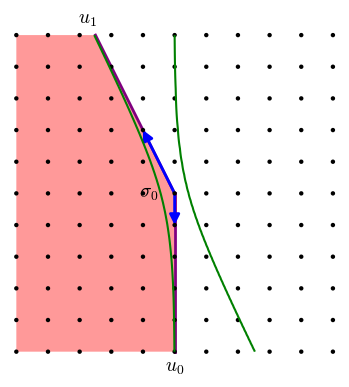

In [20]:
def get_cone_and_levset_plot(sig):
    x,y = var('x,y')
    levset = implicit_plot(get_spec_at_e(sig, (x,y)) == 0, (-5,5), (-5,5), cmap=['green'])
    Plot = levset + get_fibered_cone_plot(sig)
    return Plot

#get_cone_and_levset_plot('fLLQcbecdeepuwsua_20102')

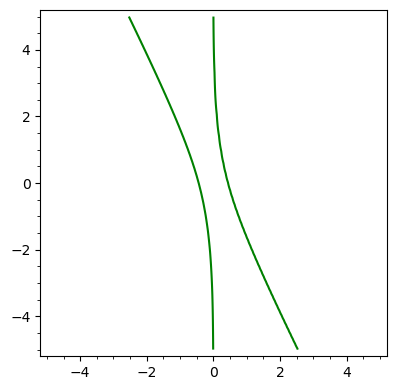

In [21]:
def get_levset_plot(sig):
    x,y = var('x,y')
    levset = implicit_plot(get_spec_at_e(sig, (x,y)) == 0, (-5,5), (-5,5), cmap=['green'])
    Plot = levset
    return Plot

get_levset_plot('fLLQcbecdeepuwsua_20102')

#taut_polynomial.taut_polynomial('hLLAAkcededfggiikajwxn_0112201')

In [22]:
#def get_min_norm_dila_direction(sig): # This doesn't really work.
#    x,y = var('x,y')
#    p = get_spec_at_e(sig, (x,y))
#    f = Thurston_norm_vars(sig, (x,y))
#    L = var('L')
#    sols = solve([diff(f,x) == L*diff(p,x), diff(f,y) == L*diff(p,y), p==0], x, y, L, algorithm='sympy')
#    print(sols)
#    for sol in sols:
#        if get_fibered_cone(sig).interior_contains((sol.get(x), sol.get(y))):
#            return (sol.get(x), sol.get(y))

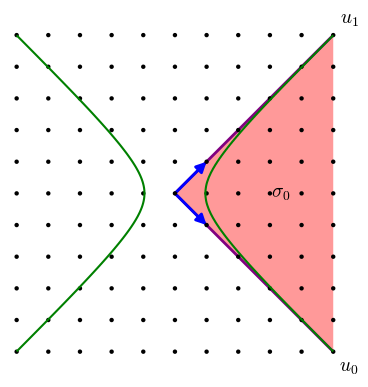

In [23]:
#get_cone_and_levset_plot('eLMkbcddddedde_2100')

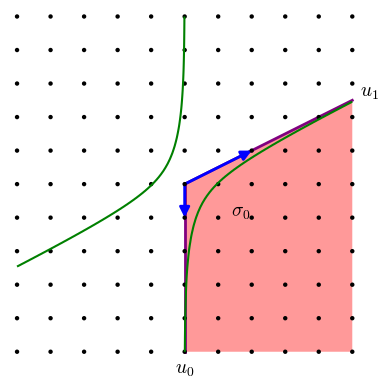

In [24]:
#get_cone_and_levset_plot('fLLQcbeddeehhbghh_01110')

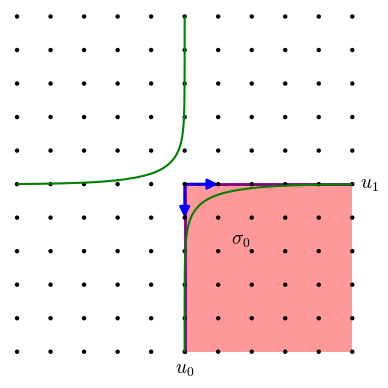

In [25]:
#get_cone_and_levset_plot('gLLAQcdecfffhsermws_122201')

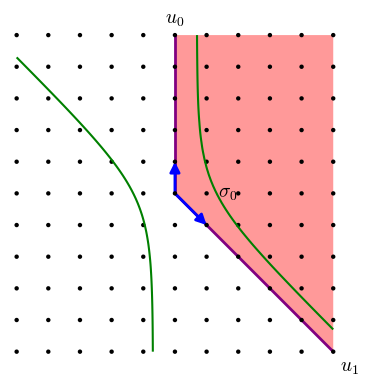

In [26]:
#get_cone_and_levset_plot('gLLPQccdfeffhggaagb_201022')

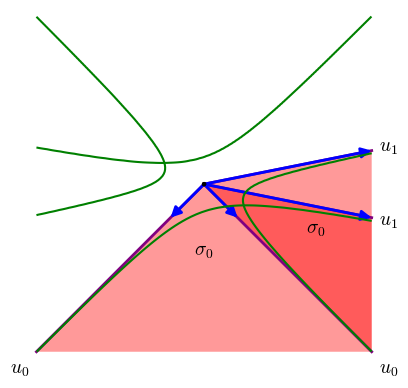

In [27]:
#first = get_cone_and_levset_plot('hLLLQkbeegefgghhhahabg_1200111')
#second = get_cone_and_levset_plot('hLLLQkbeegefgghhhahabg_0111022')

#combo = first + second
#combo.show()

In [28]:
def get_minimal_direction(sig):
    # Should probably try to figure out how to write this without having the mathematica code run three times...
    
    x,y = var('x,y')
    f = str(Thurston_norm_vars(sig, (x,y)))
    g = str(get_spec_at_e(sig, (x,y)))
    newg = g.replace("e", "E")

    #start = time.time()
    for i in range(len(m('NSolve[{Grad[' + f + ', {x,y}] == L*Grad[' + newg + ', {x,y}], ' + newg + ' == 0}, {x,y,L}, Reals]'))):
        x1 = m('x/.NSolve[{Grad[' + f + ', {x,y}] == L*Grad[' + newg + ', {x,y}], ' + newg + ' == 0}, {x,y,L}, Reals][[' + str(i+1) + ']]')
        y1 = m('y/.NSolve[{Grad[' + f + ', {x,y}] == L*Grad[' + newg + ', {x,y}], ' + newg + ' == 0}, {x,y,L}, Reals][[' + str(i+1) + ']]')
        if get_fibered_cone(sig).interior_contains((x1,y1)):
            return (x1, y1)
    #end = time.time()
    #print(end - start)
    
#get_minimal_direction('fLLQcbecdeepuwsua_20102')

In [75]:
def get_dila_mathematica(sig, point):
    poly = str(get_spec(sig, point))
    poly = poly.replace("sqrt(x)", "Sqrt[x]")
    roots = m('NSolve[' + poly + ' == 0, x]')
    root_nums = []
    for i in range(len(roots)):
        root_nums.append(m('x/.NSolve[' + poly + ' == 0, x][[' + str(i+1) + ']]'))
        
    root_nums = [abs(root.sage()) for root in root_nums]
    return max(root_nums)

In [50]:
def get_norm_dila_log_mathematica(sig, point):
    return Thurston_norm_nums(sig, point)*math.log(get_dila_mathematica(sig, point))

In [73]:
def get_min_norm_dila_log_mathematica_approx(sig):
    x1, y1 = get_minimal_direction(sig)
    point = (round(x1, 1), round(y1, 1))
    return get_norm_dila_log_mathematica(sig, point)

In [66]:
def get_min_norm_dila_log_approx(sig):
    # This one is much slower than the mathematica version.
    
    x1, y1 = get_minimal_direction(sig)
    point = (round(x1, 1), round(y1, 1))
    return get_norm_dila_log(sig, point)

In [64]:
'''# something doesn't work for'hLALMkbcbefggghhwsemws_2112201'
# The 8 tetrahedron example (the last one) takes a long time (a couple mins).
sigs = ['eLMkbcddddedde_2100', 'fLLQcbecdeepuwsua_20102', 'fLLQcbeddeehhbghh_01110', 'gLLAQcdecfffhsermws_122201', 'gLLPQccdfeffhggaagb_201022', 'gLLPQcdfefefuoaaauo_022110', 'hLLLQkacgfefggjkjjfjko_2002121', 'hLLLQkbeegefgghhhahabg_1200111', 'hLLLQkbeegefgghhhahabg_0111022', 'hLLLQkcegfeegghhhahabg_2010222', 'hLLPMkccdfeggghggaahah_2010221', 'hvLPQkcdegffggbbgaaahg_1020211', 'iLLALQcbcdefghhhtsfxjoxqt_20102120']
for sig in sigs:
    print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))'''

eLMkbcddddedde_2100 (0.9624236501192069, 0) 1.9248473002384134
fLLQcbecdeepuwsua_20102 (-0.6329743192009475, 0.6329743192009475) 2.5318972768026375
fLLQcbeddeehhbghh_01110 (0.9624236501192069, 0) 1.9248473002384134
gLLAQcdecfffhsermws_122201 (0.7473304654042903, -0.4195853731440559) 3.1730863869668617
gLLPQccdfeffhggaagb_201022 (1.3169578969248168, 0) 2.6339157938496873
gLLPQcdfefefuoaaauo_022110 (-0.5224246698222716, -0.420164001021145) 2.7144187868406435
hLLLQkacgfefggjkjjfjko_2002121 (-0.5700957170102703, -0.6591922088162503) 3.6878905795173242
hLLLQkbeegefgghhhahabg_1200111 (1.566799236972411, 0) 3.133598473944807
hLLLQkbeegefgghhhahabg_0111022 (1.265948638401895, -0.6329743192009475) 3.802970586576618
hLLLQkcegfeegghhhahabg_2010222 (0, 1.566799236972411) 3.133598473944807
hLLPMkccdfeggghggaahah_2010221 (0, 1.566799236972411) 3.133598473944807
hvLPQkcdegffggbbgaaahg_1020211 (-0.819094435969666, -1.228641653954499) 3.276377743794386
iLLALQcbcdefghhhtsfxjoxqt_20102120 (1.421837826245

In [76]:
'''sig = 'iLLALQcbcdeghhghtsjajelvu_20102121'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLALQcbcdeghhghtsjajelvu_20102121 (-0.5423881282913164, 0.9769811160689049) 4.1301837358086715
108.65987730026245


In [77]:
'''sig = 'iLLALQccedefghhhiikarbwbk_10221011'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLALQccedefghhhiikarbwbk_10221011 (0.359977719233015, -0.8637420692900316) 4.178587619485253
116.58831262588501


In [79]:
'''sig = 'iLLAMMccedefgghhiikaevfpj_10221012'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLAMMccedefgghhiikaevfpj_10221012 (-0.5397299800660715, 1.999787344214103) 4.007191831135889
81.92908978462219


In [80]:
'''sig = 'iLLAzQcbcdefhghhtsjajqjqt_20102120'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLAzQcbcdefhghhtsjajqjqt_20102120 (-0.6117078284517878, 2.0335456546972357) 3.6538111269871427
97.11644124984741


In [82]:
'''sig = 'gLLPQbefefefhhhhhha_011102'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

gLLPQbefefefhhhhhha_011102 (0, 1.3169578969248168) 2.6339157938496873
2.931986093521118


In [83]:
'''sig = 'gLPLQbdcfeffhbbaabg_120011'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

gLPLQbdcfeffhbbaabg_120011 (1.3169578969248168, 0) 2.6339157938496873
2.556971788406372


In [88]:
'''sig = 'hLLAMkcedefgggiikaevfg_1022101'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

hLLAMkcedefgggiikaevfg_1022101 (-0.8314429455293105, 2.4943288365879317) 3.3298345021230893
15.516092777252197


In [89]:
'''sig = 'iLAwMPcbcbdfghhhxxnxrpirf_01101122'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLAwMPcbcbdfghhhxxnxrpirf_01101122 (1.068136627426251, -0.24650265208791405) 4.12896742442156
116.52364492416382


In [91]:
# DON'T KNOW WHY THIS ONE DOESN'T WORK

#sig = 'iLLAMMccdecffghhhsermstqs_12220120'

#start = time.time()
#print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
#end = time.time()
#print(end-start)

In [92]:
'''sig = 'iLLAMMccedefgghhiikaevfpj_10221012'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLAMMccedefgghhiikaevfpj_10221012 (-0.5397299800660715, 1.999787344214103) 4.007191831135889
86.1435399055481


In [93]:
'''sig = 'iLLAzQcbcdefhghhtsjajqjqt_20102120'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLAzQcbcdefhghhtsjajqjqt_20102120 (-0.6117078284517878, 2.0335456546972357) 3.6538111269871427
95.50479483604431


In [94]:
'''sig = 'iLLAzQccedegghhhiinahomtu_01122000'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLAzQccedegghhhiinahomtu_01122000 (-2.415736011510805, -1.0021230939414352) 4.009220862887897
122.25129389762878


In [95]:
'''sig = 'iLLLAQcccgeghghhlntiaqgqa_12001112'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLAQcccgeghghhlntiaqgqa_12001112 (1.13992634388833, 1.7858048383648508) 3.6208892186110684
136.03736281394958


In [96]:
'''sig = 'iLLLMQcbefghfhghhhexlgkrk_01110220'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLMQcbefghfhghhhexlgkrk_01110220 (-0.5074485851780107, 0) 4.059588681423291
132.6486279964447


In [98]:
# DON'T KNOW WHY THIS ONE DOESN'T WORK
#sig = 'iLLLQPcbeegefhhhhhhahahha_01110221'

#start = time.time()
#print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
#end = time.time()
#print(end-start)

In [99]:
'''sig = 'iLLLQPcbeegefhhhhhhahahha_12001112'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLQPcbeegefhhhhhhahahha_12001112 (0, 1.762747174039086) 3.5254943480781726
76.79661297798157


In [100]:
'''sig = 'iLLLQPcceegfghhhiimaimimi_10221212'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLQPcceegfghhhiimaimimi_10221212 (0.9624236501192069, 0.) 3.84969460047682
82.1824083328247


In [101]:
'''sig = 'iLLLQPccefgeghhhhdupmmadl_20102100'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLQPccefgeghhhhdupmmadl_20102100 (1.9248473002384139, 0.9624236501192069) 3.853142470476399
89.49657797813416


In [102]:
'''sig = 'iLLLQPccegfeehhhhhhahahha_20102221'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLLQPccegfeehhhhhhahahha_20102221 (0, 1.762747174039086) 3.5254943480781726
96.28414916992188


In [103]:
'''sig = 'iLLPMPcccdfeghhhhggaahhgb_20102211'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLPMPcccdfeghhhhggaahhgb_20102211 (0, 1.762747174039086) 3.5254943480781726
92.41481614112854


In [104]:
'''sig = 'iLLPwQcccdfehghhhggaahhbg_20102211'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLPwQcccdfehghhhggaahhbg_20102211 (1.2187557268720124, 0.6093778634360062) 3.656267180500225
92.2199113368988


In [105]:
'''sig = 'iLLvQQcbeghfhhgghhaaabgbg_12001111'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLvQQcbeghfhhgghhaaabgbg_12001111 (1.762747174039086, 0) 3.5254943480781726
108.69259190559387


In [106]:
'''sig = 'iLLwQPcbeefgehhhxxxaaxxxa_10221110'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLwQPcbeefgehhhxxxaaxxxa_10221110 (0, 1.762747174039086) 3.5254943480781726
81.5627031326294


In [107]:
'''sig = 'iLLzPQccdcghfhghhsrwsbwwg_12220110'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLzPQccdcghfhghhsrwsbwwg_12220110 (-0.7410191780716097, 1.193948933590281) 4.498163935125074
106.2988109588623


In [108]:
'''sig = 'iLLzPQccdegfhhghhsahfssoj_10001212'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLLzPQccdegfhhghhsahfssoj_10001212 (0.8314429455293105, 0.8314429455293105) 3.325771782167344
85.18193984031677


In [109]:
'''sig = 'iLvLQQcbehfghgghhhhahbbgg_21112200'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLvLQQcbehfghgghhhhahbbgg_21112200 (0.9178186079574091, 1.3767279119361138) 4.5916497549124236
113.83012795448303


In [110]:
'''sig = 'iLvLQQcceehgfghhpaaauvvbb_10221110'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

iLvLQQcceehgfghhpaaauvvbb_10221110 (1.638188871939332, -0.409547217984833) 3.276377743794386
112.62945318222046


In [116]:
# DON'T KNOW WHY THIS ONE DOESN'T WORK
#sig = 'ivLAAQcecefghhghfbbaaafbb_12222010'

#start = time.time()
#print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
#end = time.time()
#print(end-start)

In [112]:
'''sig = 'ivLLQQccdhghgfhggrqlipigb_12020011'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivLLQQccdhghgfhggrqlipigb_12020011 (1.4218378262454479, 2.2319678240391077) 3.653811127700625
101.58177924156189


In [113]:
'''sig = 'ivLLQQccfhfeghghwadiwadrv_20110220'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivLLQQccfhfeghghwadiwadrv_20110220 (-0.81012999779366, 0.6117078284517878) 3.6538111286261006
83.82352924346924


In [114]:
'''sig = 'ivvPQQcfghghfghfahhhhaaaa_10000122'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcfghghfghfahhhhaaaa_10000122 (0, 1.762747174039086) 3.5254943480781726
73.38595795631409


In [115]:
'''sig = 'ivvPQQcfghghfghfahhhhaaaa_20000211'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcfghghfghfahhhhaaaa_20000211 (1.762747174039086, 0.) 3.5254943480781726
73.71093201637268


In [117]:
'''sig = 'ivvPQQcfghghfghfaxxxxaaaa_20000211'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcfghghfghfaxxxxaaaa_20000211 (0, 1.762747174039086) 3.5254943480781726
80.88836717605591


In [118]:
'''sig = 'ivvPQQcfghghfhgfaddddaaaa_20000222'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcfghghfhgfaddddaaaa_20000222 (0, 1.566799236972411) 3.133598473944807
101.09182620048523


In [119]:
'''sig = 'ivvPQQcfhgghfhgfaaahhahha_10000122'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcfhgghfhgfaaahhahha_10000122 (0, 1.762747174039086) 3.5254943480781726
68.50353074073792


In [120]:
'''sig = 'ivvPQQcgfhfhgfghappppaaaa_21001020'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

ivvPQQcgfhfhgfghappppaaaa_21001020 (1.9248473002384139, 0) 3.8496882750124537
97.97040319442749


In [123]:
# DON'T KNOW WHY THIS ONE DOESN'T WORK
#sig = 'jLALMPPbcbefgghiihhwsemstqs_211220120'

#start = time.time()
#print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
#end = time.time()
#print(end-start)

In [122]:
'''sig = 'jLALvQQbcbehigihihhwswsbwwg_211220110'

start = time.time()
print(sig, get_minimal_direction(sig), get_min_norm_dila_log_mathematica_approx(sig))
end = time.time()
print(end-start)'''

jLALvQQbcbehigihihhwswsbwwg_211220110 (-0.8946169819877622, -0.5476012321819127) 5.122419892491834
895.515496969223
